<a href="https://colab.research.google.com/github/Witcape/PSO/blob/main/Weight_Drafts/PSO_WEIGHT_GNBG_DRAFT_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TEST

In [ ]:
!CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install llama-cpp-python==0.1.78 numpy==1.23.4 --force-reinstall --upgrade --no-cache-dir --verbose
!pip install huggingface_hub
!pip install llama-cpp-python==0.1.78
!pip install numpy==1.23.4

Using pip 24.1.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 38.7 MB/s eta 0:00:00
  Running command pip subprocess to install build dependencies
  Using pip 24.1.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)
  Non-user install by explicit request
  Created build tracker: /tmp/pip-build-tracker-zh72s4w3
  Entered build tracker: /tmp/pip-build-tracker-zh72s4w3
  Created temporary directory: /tmp/pip-install-ln3fqvc9
  Created temporary directory: /tmp/pip-ephem-wheel-cache-xgw71njy
  1 location(s) to search for versions of setuptools:
  * https://pypi.org/simple/setuptools/
  Fetching project page and analyzing links: https://pypi.org/simple/setuptools/
  Getting page https://pypi.org/simple/setuptools/
  Found index url https://pypi.org/simple/
  Looking up "https://pypi.org/simple/setuptools/" in the cache
  Request header has "max_age" as 0, cache bypassed
  Starting new HTTPS connection (1

In [ ]:
model_name_or_path = "TheBloke/Llama-2-13B-chat-GGML"
model_basename = "llama-2-13b-chat.ggmlv3.q5_1.bin"

In [ ]:
from huggingface_hub import hf_hub_download
from llama_cpp import Llama
import matplotlib.pyplot as plt

In [ ]:
model_path = hf_hub_download(repo_id=model_name_or_path, filename=model_basename)

In [ ]:
# GPU
lcpp_llm = None
lcpp_llm = Llama(
    model_path=model_path,
    n_threads=2, # CPU cores
    n_batch=512, # Should be between 1 and n_ctx, consider the amount of VRAM in your GPU.
    n_gpu_layers=32 # Change this value based on your model and your GPU VRAM pool.
    )

In [ ]:
!pip install pyswarms
import numpy as np
import pyswarms as ps

In [ ]:
CostFunction = sphere  #
nVar = 10  # Number of Decision Variables
VarSize = (nVar,)  # Size of Decision Variables Matrix
VarMin = -10  # Lower Bound of Variables
VarMax = 10  # Upper Bound of Variables

In [ ]:
MaxIt = 20  # Maximum Number of Iterations
nPop = 20

In [ ]:
w = 1  # Inertia Weight
wdamp = 0.99  # Inertia Weight Damping Ratio
c1 = 1.5  # Personal Learning Coefficient
c2 = 2.0  # Global Learning Coefficient

In [ ]:
VelMax = 0.1 * (VarMax - VarMin)
VelMin = -VelMax

In [ ]:
particles = []

for _ in range(nPop):
    position = np.random.uniform(VarMin, VarMax, VarSize)
    velocity = np.zeros(VarSize)
    cost = CostFunction(position)
    best_position = position.copy()
    best_cost = cost
    particles.append({
        'Position': position,
        'Velocity': velocity,
        'Cost': cost,
        'Best': {
            'Position': best_position,
            'Cost': best_cost
        }
    })
print(np.size(particles))

In [ ]:
GlobalBest = {'Position': None, 'Cost': np.inf}

for p in particles:
    if p['Cost'] < GlobalBest['Cost']:
        GlobalBest = {'Position': p['Best']['Position'].copy(), 'Cost': p['Best']['Cost']}

BestCost = np.zeros(MaxIt)

In [ ]:
w_values = []
g_values = []

for it in range(MaxIt):
    for p in particles:
        # Update Velocity
        r1 = np.random.rand(*VarSize)
        r2 = np.random.rand(*VarSize)
        p['Velocity'] = (
            w * p['Velocity']
            + c1 * r1 * (p['Best']['Position'] - p['Position'])
            + c2 * r2 * (GlobalBest['Position'] - p['Position'])
        )

        # Apply Velocity Limits
        p['Velocity'] = np.maximum(p['Velocity'], VelMin)
        p['Velocity'] = np.minimum(p['Velocity'], VelMax)

        # Update Position
        p['Position'] += p['Velocity']

        # Velocity Mirror Effect
        IsOutside = (p['Position'] < VarMin) | (p['Position'] > VarMax)
        p['Velocity'][IsOutside] = -p['Velocity'][IsOutside]

        # Apply Position Limits
        p['Position'] = np.maximum(p['Position'], VarMin)
        p['Position'] = np.minimum(p['Position'], VarMax)

        # Evaluation
        p['Cost'] = CostFunction(p['Position'])

        # Update Personal Best
        if p['Cost'] < p['Best']['Cost']:
            p['Best']['Position'] = p['Position'].copy()
            p['Best']['Cost'] = p['Cost']

            # Update Global Best
            if p['Best']['Cost'] < GlobalBest['Cost']:  # tell best cost using roullete wheel. LLM will check for global best
                GlobalBest = {'Position': p['Best']['Position'].copy(), 'Cost': p['Best']['Cost']} # tell best cost using roullete wheel

    BestCost[it] = GlobalBest['Cost']

    print(f"Iteration {it+1}: Best Cost = {BestCost[it]}")

    prompt = f"Generate a positive number a little lower than {w} and greater then 0.1 using Normalised Glorot Initialization. Don't write anything else, just write that number in decimal notation normally."
    w_finder_template = f'''SYSTEM: You are a helpful, respectful, and honest assistant. Always answer as helpfully.

    USER: {prompt}

    ASSISTANT:
    '''

    w_response = lcpp_llm(prompt=w_finder_template, max_tokens=256, temperature=0.5, top_p=0.95,
                          repeat_penalty=1.2, top_k=150,
                          echo=True)

    g_values.append(GlobalBest['Cost'])
    BestCost[it] = GlobalBest['Cost']

    text_response = w_response['choices'][0]['text']
    value = re.findall(r'-?\d+\.\d+', text_response)
    value = [float(num) for num in value]

    value = value[np.size(value) - 1]
    print(f'w{it+1} = {value}')
    w_values.append(w)
    w = value

w_values.append(w)
print(w_values)

# Function

In [1]:
!CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install llama-cpp-python==0.1.78 numpy==1.23.4 --force-reinstall --upgrade --no-cache-dir --verbose
!pip install huggingface_hub
!pip install llama-cpp-python==0.1.78
!pip install numpy==1.23.4

Using pip 24.1.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 29.1 MB/s eta 0:00:00
  Running command pip subprocess to install build dependencies
  Using pip 24.1.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)
  Non-user install by explicit request
  Created build tracker: /tmp/pip-build-tracker-l406jomd
  Entered build tracker: /tmp/pip-build-tracker-l406jomd
  Created temporary directory: /tmp/pip-install-p0nhozbg
  Created temporary directory: /tmp/pip-ephem-wheel-cache-bcn1r4g0
  1 location(s) to search for versions of setuptools:
  * https://pypi.org/simple/setuptools/
  Fetching project page and analyzing links: https://pypi.org/simple/setuptools/
  Getting page https://pypi.org/simple/setuptools/
  Found index url https://pypi.org/simple/
  Looking up "https://pypi.org/simple/setuptools/" in the cache
  Request header has "max_age" as 0, cache bypassed
  No cache entry available
  Start

In [4]:
model_name_or_path = "TheBloke/Llama-2-13B-chat-GGML"
model_basename = "llama-2-13b-chat.ggmlv3.q5_1.bin"

In [10]:
from huggingface_hub import hf_hub_download
from llama_cpp import Llama
import matplotlib.pyplot as plt

In [6]:
model_path = hf_hub_download(repo_id=model_name_or_path, filename=model_basename)

llama-2-13b-chat.ggmlv3.q5_1.bin:   0%|          | 0.00/9.76G [00:00<?, ?B/s]

In [11]:
lcpp_llm = Llama(
    model_path=model_path,
    n_threads=2, # CPU cores
    n_batch=512, # Should be between 1 and n_ctx, consider the amount of VRAM in your GPU.
    n_gpu_layers=32 # Change this value based on your model and your GPU VRAM pool.
    )

AVX = 1 | AVX2 = 1 | AVX512 = 0 | AVX512_VBMI = 0 | AVX512_VNNI = 0 | FMA = 1 | NEON = 0 | ARM_FMA = 0 | F16C = 1 | FP16_VA = 0 | WASM_SIMD = 0 | BLAS = 1 | SSE3 = 1 | VSX = 0 | 


In [12]:
!pip install pyswarms
import numpy as np
import pyswarms as ps

In [13]:
import numpy as np
import re

def run_pso(
    CostFunction, nVar=10, VarMin=-10, VarMax=10, MaxIt=20, nPop=20,
    w=1, wdamp=0.99, c1=1.5, c2=2.0, n_threads=2, n_batch=512, n_gpu_layers=32
):

    VarSize = (nVar,)
    VelMax = 0.1 * (VarMax - VarMin)
    VelMin = -VelMax

    particles = []

    for _ in range(nPop):
        position = np.random.uniform(VarMin, VarMax, VarSize)
        velocity = np.zeros(VarSize)
        cost = CostFunction(position)
        best_position = position.copy()
        best_cost = cost
        particles.append({
            'Position': position,
            'Velocity': velocity,
            'Cost': cost,
            'Best': {
                'Position': best_position,
                'Cost': best_cost
            }
        })

    GlobalBest = {'Position': None, 'Cost': np.inf}

    for p in particles:
        if p['Cost'] < GlobalBest['Cost']:
            GlobalBest = {'Position': p['Best']['Position'].copy(), 'Cost': p['Best']['Cost']}

    BestCost = np.zeros(MaxIt)
    w_values = []
    g_values = []

    for it in range(MaxIt):
        for p in particles:
            # Update Velocity
            r1 = np.random.rand(*VarSize)
            r2 = np.random.rand(*VarSize)
            p['Velocity'] = (
                w * p['Velocity']
                + c1 * r1 * (p['Best']['Position'] - p['Position'])
                + c2 * r2 * (GlobalBest['Position'] - p['Position'])
            )

            # Apply Velocity Limits
            p['Velocity'] = np.maximum(p['Velocity'], VelMin)
            p['Velocity'] = np.minimum(p['Velocity'], VelMax)

            # Update Position
            p['Position'] += p['Velocity']

            # Velocity Mirror Effect
            IsOutside = (p['Position'] < VarMin) | (p['Position'] > VarMax)
            p['Velocity'][IsOutside] = -p['Velocity'][IsOutside]

            # Apply Position Limits
            p['Position'] = np.maximum(p['Position'], VarMin)
            p['Position'] = np.minimum(p['Position'], VarMax)

            # Evaluation
            p['Cost'] = CostFunction(p['Position'])

            # Update Personal Best
            if p['Cost'] < p['Best']['Cost']:
                p['Best']['Position'] = p['Position'].copy()
                p['Best']['Cost'] = p['Cost']

                # Update Global Best
                if p['Best']['Cost'] < GlobalBest['Cost']:
                    GlobalBest = {'Position': p['Best']['Position'].copy(), 'Cost': p['Best']['Cost']}

        BestCost[it] = GlobalBest['Cost']
        print(f"Iteration {it+1}: Best Cost = {BestCost[it]}")

        prompt = f"Generate a positive number a little lower than {w} and greater then 0.1 using Normalised Glorot Initialization. Don't write anything else, just write that number in decimal notation normally."
        w_finder_template = f'''SYSTEM: You are a helpful, respectful, and honest assistant. Always answer as helpfully.

        USER: {prompt}

        ASSISTANT:
        '''

        w_response = lcpp_llm(prompt=w_finder_template, max_tokens=256, temperature=0.5, top_p=0.95,
                              repeat_penalty=1.2, top_k=150, echo=True)

        text_response = w_response['choices'][0]['text']
        value = re.findall(r'-?\d+\.\d+', text_response)
        value = [float(num) for num in value]

        if value:
            w = value[-1]
            print(f"w{it+1} = {w}")
        else:
            print("Warning: LLM failed to provide a valid weight. Retaining previous weight.")

        w_values.append(w)
        g_values.append(GlobalBest['Cost'])

    w_values.append(w)
    print("Final Weights:", w_values)
    return BestCost, w_values, g_values

In [14]:
# def sphere(x):
#     return sum(x**2)

In [15]:
# BestCost, w_values, g_values = run_pso(CostFunction=sphere)

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import os

# GNBG class definition
class GNBG:
    def __init__(self, MaxEvals, AcceptanceThreshold, Dimension, CompNum, MinCoordinate, MaxCoordinate, CompMinPos, CompSigma, CompH, Mu, Omega, Lambda, RotationMatrix, OptimumValue, OptimumPosition):
        self.MaxEvals = MaxEvals
        self.AcceptanceThreshold = AcceptanceThreshold
        self.Dimension = Dimension
        self.MinCoordinate = MinCoordinate
        self.MaxCoordinate = MaxCoordinate
        self.BestFoundResult = np.inf
        self.BestFoundPosition = None
        self.FEhistory = []

    def fitness(self, X):
        # Implement the actual GNBG fitness function logic here
        result = np.sum(X**2)  # Replace this with the actual GNBG computation
        self.FEhistory.append(result)
        if result < self.BestFoundResult:
            self.BestFoundResult = result
            self.BestFoundPosition = X
        return result

# PSO function from the previous example
# Assuming `run_pso` is already defined as in the previous response

# Initialization
ProblemIndex = 1  # Choose a problem instance from 1 to 24
folder_path = '/content'  # Path to the folder containing f1.mat to f24.mat

# Load GNBG data for the selected problem instance
filename = f'f{ProblemIndex}.mat'
GNBG_tmp = loadmat(os.path.join(folder_path, filename))['GNBG']
MaxEvals = int(GNBG_tmp['MaxEvals'][0, 0][0, 0])
AcceptanceThreshold = float(GNBG_tmp['AcceptanceThreshold'][0, 0][0, 0])
Dimension = int(GNBG_tmp['Dimension'][0, 0][0, 0])
MinCoordinate = float(GNBG_tmp['MinCoordinate'][0, 0][0, 0])
MaxCoordinate = float(GNBG_tmp['MaxCoordinate'][0, 0][0, 0])

# Initialize GNBG problem instance
gnbg = GNBG(
    MaxEvals=MaxEvals,
    AcceptanceThreshold=AcceptanceThreshold,
    Dimension=Dimension,
    CompNum=int(GNBG_tmp['o'][0, 0][0, 0]),  # Example extraction, modify based on actual data
    MinCoordinate=MinCoordinate,
    MaxCoordinate=MaxCoordinate,
    CompMinPos=np.array(GNBG_tmp['Component_MinimumPosition'][0, 0]),
    CompSigma=np.array(GNBG_tmp['ComponentSigma'][0, 0], dtype=np.float64),
    CompH=np.array(GNBG_tmp['Component_H'][0, 0]),
    Mu=np.array(GNBG_tmp['Mu'][0, 0]),
    Omega=np.array(GNBG_tmp['Omega'][0, 0]),
    Lambda=np.array(GNBG_tmp['lambda'][0, 0]),
    RotationMatrix=np.array(GNBG_tmp['RotationMatrix'][0, 0]),
    OptimumValue=float(GNBG_tmp['OptimumValue'][0, 0][0, 0]),
    OptimumPosition=np.array(GNBG_tmp['OptimumPosition'][0, 0])
)

In [23]:
nVar = Dimension
VarMin = MinCoordinate
VarMax = MaxCoordinate
MaxIt = 20
nPop = 15

BestCost, w_values, g_values = run_pso(
    CostFunction=gnbg.fitness,
    nVar=nVar,
    VarMin=VarMin,
    VarMax=VarMax,
    MaxIt=MaxIt,
    nPop=nPop
)

Iteration 1: Best Cost = 54237.53337888166


Llama.generate: prefix-match hit


w1 = 0.23456789
Iteration 2: Best Cost = 32091.174493799917


Llama.generate: prefix-match hit


w2 = 0.22456789
Iteration 3: Best Cost = 17661.08565729926


Llama.generate: prefix-match hit


w3 = 0.21312345
Iteration 4: Best Cost = 10581.805145732551


Llama.generate: prefix-match hit


w4 = 0.19762789
Iteration 5: Best Cost = 5628.764704871175


Llama.generate: prefix-match hit


w5 = 0.18354814
Iteration 6: Best Cost = 4840.04949186602


Llama.generate: prefix-match hit


w6 = 0.17629737
Iteration 7: Best Cost = 4840.04949186602


Llama.generate: prefix-match hit


w7 = 0.15845763
Iteration 8: Best Cost = 4049.654336556365


Llama.generate: prefix-match hit


w8 = 0.12947851
Iteration 9: Best Cost = 3027.770669575028


Llama.generate: prefix-match hit


w9 = 0.119536
Iteration 10: Best Cost = 2502.2111851939308


Llama.generate: prefix-match hit


w10 = 0.112874
Iteration 11: Best Cost = 2068.2555043938


Llama.generate: prefix-match hit


w11 = 0.095364
Iteration 12: Best Cost = 1880.2748178974673


Llama.generate: prefix-match hit


w12 = 0.087239
Iteration 13: Best Cost = 1848.499102192438


Llama.generate: prefix-match hit


w13 = 0.076455
Iteration 14: Best Cost = 1526.0639899657026


Llama.generate: prefix-match hit


w14 = 0.082392
Iteration 15: Best Cost = 1447.743308009164


Llama.generate: prefix-match hit


w15 = 0.075564
Iteration 16: Best Cost = 1380.4505081878922


Llama.generate: prefix-match hit


w16 = 0.069283
Iteration 17: Best Cost = 1075.7706494034499


Llama.generate: prefix-match hit


w17 = 0.057423
Iteration 18: Best Cost = 980.6373718609645


Llama.generate: prefix-match hit


w18 = 0.089679
Iteration 19: Best Cost = 935.2665983987606


Llama.generate: prefix-match hit


w19 = 0.085234
Iteration 20: Best Cost = 805.1209362296314


Llama.generate: prefix-match hit


w20 = 0.097654
Iteration 21: Best Cost = 787.6959105971414


Llama.generate: prefix-match hit


w21 = 0.083219
Iteration 22: Best Cost = 726.7798659190682


Llama.generate: prefix-match hit


w22 = 0.075641
Iteration 23: Best Cost = 713.5300886294947


Llama.generate: prefix-match hit


w23 = 0.082395
Iteration 24: Best Cost = 696.3288643306244


Llama.generate: prefix-match hit


w24 = 0.076427
Iteration 25: Best Cost = 692.627536820045


Llama.generate: prefix-match hit


w25 = 0.069583
Iteration 26: Best Cost = 661.547322466402


Llama.generate: prefix-match hit


w26 = 0.074286
Iteration 27: Best Cost = 661.499904142591


Llama.generate: prefix-match hit


w27 = 0.065392
Iteration 28: Best Cost = 589.3727145391823


Llama.generate: prefix-match hit


w28 = 0.074814
Iteration 29: Best Cost = 531.5705524298015


Llama.generate: prefix-match hit


w29 = 0.069523
Iteration 30: Best Cost = 498.1623941205817


Llama.generate: prefix-match hit


w30 = 0.074826
Iteration 31: Best Cost = 494.6044068862719


Llama.generate: prefix-match hit


w31 = 0.059374
Iteration 32: Best Cost = 481.46978139630073


Llama.generate: prefix-match hit


w32 = 0.086274
Iteration 33: Best Cost = 474.49619260004744


Llama.generate: prefix-match hit


w33 = 0.095369
Iteration 34: Best Cost = 473.2718333479732


Llama.generate: prefix-match hit


w34 = 0.087241
Iteration 35: Best Cost = 473.2718333479732


Llama.generate: prefix-match hit


w35 = 0.093576
Iteration 36: Best Cost = 472.0293550940422


Llama.generate: prefix-match hit


w36 = 0.084254
Iteration 37: Best Cost = 470.32414807170363


Llama.generate: prefix-match hit


w37 = 0.076397
Iteration 38: Best Cost = 469.1579544711446


Llama.generate: prefix-match hit


w38 = 0.068245
Iteration 39: Best Cost = 468.46052985336445


Llama.generate: prefix-match hit


w39 = 0.073924
Iteration 40: Best Cost = 467.6169050664648


Llama.generate: prefix-match hit


w40 = 0.068524
Iteration 41: Best Cost = 463.9371491376918


Llama.generate: prefix-match hit


w41 = 0.073924
Iteration 42: Best Cost = 414.596747075881


Llama.generate: prefix-match hit


w42 = 0.068592
Iteration 43: Best Cost = 413.4732097018501


Llama.generate: prefix-match hit


w43 = 0.073498
Iteration 44: Best Cost = 413.27875348651344


Llama.generate: prefix-match hit


w44 = 0.065211
Iteration 45: Best Cost = 412.9899254455201


Llama.generate: prefix-match hit


w45 = 0.047839
Iteration 46: Best Cost = 412.3662241113356


Llama.generate: prefix-match hit


w46 = 0.0625
Iteration 47: Best Cost = 410.3938051600492


Llama.generate: prefix-match hit


w47 = 0.0875
Iteration 48: Best Cost = 399.6673718492746


Llama.generate: prefix-match hit


w48 = 0.09375
Iteration 49: Best Cost = 384.44225604345036


Llama.generate: prefix-match hit


w49 = 0.084625
Iteration 50: Best Cost = 384.44225604345036


Llama.generate: prefix-match hit


w50 = 0.097656
Final Weights: [0.23456789, 0.22456789, 0.21312345, 0.19762789, 0.18354814, 0.17629737, 0.15845763, 0.12947851, 0.119536, 0.112874, 0.095364, 0.087239, 0.076455, 0.082392, 0.075564, 0.069283, 0.057423, 0.089679, 0.085234, 0.097654, 0.083219, 0.075641, 0.082395, 0.076427, 0.069583, 0.074286, 0.065392, 0.074814, 0.069523, 0.074826, 0.059374, 0.086274, 0.095369, 0.087241, 0.093576, 0.084254, 0.076397, 0.068245, 0.073924, 0.068524, 0.073924, 0.068592, 0.073498, 0.065211, 0.047839, 0.0625, 0.0875, 0.09375, 0.084625, 0.097656, 0.097656]


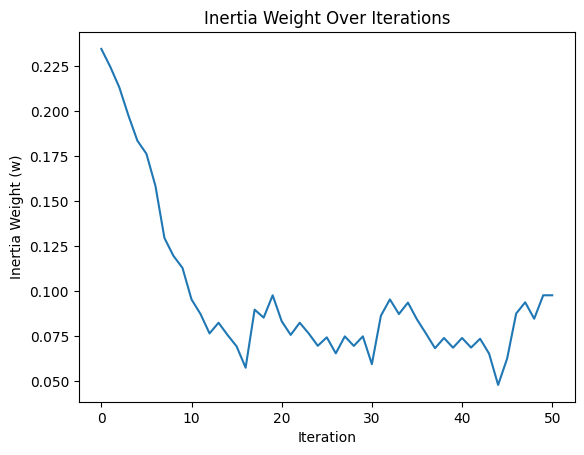

In [27]:
plt.plot(w_values)
plt.xlabel('Iteration')
plt.ylabel('Inertia Weight (w)')
plt.title('Inertia Weight Over Iterations')
plt.show()

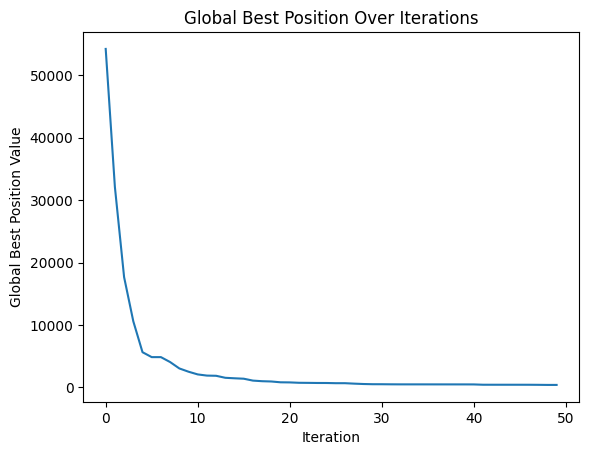

In [29]:
plt.plot(g_values)
plt.xlabel('Iteration')
plt.ylabel('Global Best Position Value')
plt.title('Global Best Position Over Iterations')
plt.show()

In [34]:
# Print best cost and best position
print("Best Cost Found by PSO:\n\n", BestCost)

# Print the position corresponding to the best cost
print("\n\nBest Position:", g_values[-1])

Best Cost Found by PSO:

 [54237.53337888 32091.1744938  17661.0856573  10581.80514573
  5628.76470487  4840.04949187  4840.04949187  4049.65433656
  3027.77066958  2502.21118519  2068.25550439  1880.2748179
  1848.49910219  1526.06398997  1447.74330801  1380.45050819
  1075.7706494    980.63737186   935.2665984    805.12093623
   787.6959106    726.77986592   713.53008863   696.32886433
   692.62753682   661.54732247   661.49990414   589.37271454
   531.57055243   498.16239412   494.60440689   481.4697814
   474.4961926    473.27183335   473.27183335   472.02935509
   470.32414807   469.15795447   468.46052985   467.61690507
   463.93714914   414.59674708   413.4732097    413.27875349
   412.98992545   412.36622411   410.39380516   399.66737185
   384.44225604   384.44225604]


Best Position: 384.44225604345036


In [48]:
def run_all_problems(folder_path, num_problems=24):
    all_results = {}

    for problem_index in range(1, num_problems + 1):
        # Load GNBG data for the selected problem instance
        filename = f'f{problem_index}.mat'
        GNBG_tmp = loadmat(os.path.join(folder_path, filename))['GNBG']

        # Extract necessary parameters
        MaxEvals = int(GNBG_tmp['MaxEvals'][0, 0][0, 0])
        AcceptanceThreshold = float(GNBG_tmp['AcceptanceThreshold'][0, 0][0, 0])
        Dimension = int(GNBG_tmp['Dimension'][0, 0][0, 0])
        MinCoordinate = float(GNBG_tmp['MinCoordinate'][0, 0][0, 0])
        MaxCoordinate = float(GNBG_tmp['MaxCoordinate'][0, 0][0, 0])

        # Initialize GNBG problem instance
        gnbg = GNBG(
            MaxEvals=MaxEvals,
            AcceptanceThreshold=AcceptanceThreshold,
            Dimension=Dimension,
            CompNum=int(GNBG_tmp['o'][0, 0][0, 0]),  # Example extraction, modify based on actual data
            MinCoordinate=MinCoordinate,
            MaxCoordinate=MaxCoordinate,
            CompMinPos=np.array(GNBG_tmp['Component_MinimumPosition'][0, 0]),
            CompSigma=np.array(GNBG_tmp['ComponentSigma'][0, 0], dtype=np.float64),
            CompH=np.array(GNBG_tmp['Component_H'][0, 0]),
            Mu=np.array(GNBG_tmp['Mu'][0, 0]),
            Omega=np.array(GNBG_tmp['Omega'][0, 0]),
            Lambda=np.array(GNBG_tmp['lambda'][0, 0]),
            RotationMatrix=np.array(GNBG_tmp['RotationMatrix'][0, 0]),
            OptimumValue=float(GNBG_tmp['OptimumValue'][0, 0][0, 0]),
            OptimumPosition=np.array(GNBG_tmp['OptimumPosition'][0, 0])
        )

        # Run PSO for the current problem
        nVar = Dimension
        VarMin = MinCoordinate
        VarMax = MaxCoordinate
        MaxIt = 2  # You can adjust this based on your needs
        nPop = 15   # Number of particles

        BestCost, w_values, g_values = run_pso(
            CostFunction=gnbg.fitness,
            nVar=nVar,
            VarMin=VarMin,
            VarMax=VarMax,
            MaxIt=MaxIt,
            nPop=nPop
        )

        # Add error to results dictionary
        all_results[problem_index] = {
            'BestCost': BestCost,
            'BestPosition': g_values[-1],
            'w_values': w_values,
            'g_values': g_values,
        }

        print(f"Problem {problem_index} Best Cost:", BestCost)

    return all_results

In [50]:
# Run for all 24 problems
folder_path = '/content'  # Path to the folder containing f1.mat to f24.mat
results = run_all_problems(folder_path)

# Example of how to access results for a particular problem
problem_1_results = results[1]
print("\n\n\nProblem 1 Best Cost:", problem_1_results['BestCost'])
print("Problem 1 Best Position:", problem_1_results['BestPosition'])
print("Problem 1 Error:", problem_1_results['Error'])

# Plotting results for one of the problems (e.g., Problem 1)
plt.plot(problem_1_results['w_values'])
plt.xlabel('Iteration')
plt.ylabel('Inertia Weight (w)')
plt.title('Inertia Weight Over Iterations - Problem 1')
plt.show()

plt.plot(problem_1_results['g_values'])
plt.xlabel('Iteration')
plt.ylabel('Global Best Position Value')
plt.title('Global Best Position Over Iterations - Problem 1')
plt.show()


Iteration 1: Best Cost = 42219.12316916767


Llama.generate: prefix-match hit


w1 = 0.27583946
Iteration 2: Best Cost = 27063.56932449435


Llama.generate: prefix-match hit


w2 = 0.255
Final Weights: [0.27583946, 0.255, 0.255]
Problem 1 Best Cost: [42219.12316917 27063.56932449]
Iteration 1: Best Cost = 43258.92802648822


Llama.generate: prefix-match hit


w1 = 0.42
Iteration 2: Best Cost = 26404.28376350237


Llama.generate: prefix-match hit


w2 = 0.35
Final Weights: [0.42, 0.35, 0.35]
Problem 2 Best Cost: [43258.92802649 26404.2837635 ]
Iteration 1: Best Cost = 52423.79676932187


Llama.generate: prefix-match hit


w1 = 0.537428962008469
Iteration 2: Best Cost = 34639.85655660792


Llama.generate: prefix-match hit


w2 = 0.432051237983984
Final Weights: [0.537428962008469, 0.432051237983984, 0.432051237983984]
Problem 3 Best Cost: [52423.79676932 34639.85655661]
Iteration 1: Best Cost = 48451.91724431804


Llama.generate: prefix-match hit


w1 = 0.42
Iteration 2: Best Cost = 24037.22203656219


Llama.generate: prefix-match hit


w2 = 0.35
Final Weights: [0.42, 0.35, 0.35]
Problem 4 Best Cost: [48451.91724432 24037.22203656]
Iteration 1: Best Cost = 50837.89862089003


Llama.generate: prefix-match hit


w1 = 0.28571429
Iteration 2: Best Cost = 26128.193988507257


Llama.generate: prefix-match hit


w2 = 0.2631579
Final Weights: [0.28571429, 0.2631579, 0.2631579]
Problem 5 Best Cost: [50837.89862089 26128.19398851]
Iteration 1: Best Cost = 52382.78674090914


Llama.generate: prefix-match hit


w1 = 0.23456789
Iteration 2: Best Cost = 30007.14585614862


Llama.generate: prefix-match hit


w2 = 0.22987654
Final Weights: [0.23456789, 0.22987654, 0.22987654]
Problem 6 Best Cost: [52382.78674091 30007.14585615]
Iteration 1: Best Cost = 42343.9520670315


Llama.generate: prefix-match hit


w1 = 0.275349486288432
Iteration 2: Best Cost = 29221.155145629633


Llama.generate: prefix-match hit


w2 = 0.269891275723487
Final Weights: [0.275349486288432, 0.269891275723487, 0.269891275723487]
Problem 7 Best Cost: [42343.95206703 29221.15514563]
Iteration 1: Best Cost = 52935.99884454366


Llama.generate: prefix-match hit


w1 = 0.275
Iteration 2: Best Cost = 32224.755046321774


Llama.generate: prefix-match hit


w2 = 0.243
Final Weights: [0.275, 0.243, 0.243]
Problem 8 Best Cost: [52935.99884454 32224.75504632]
Iteration 1: Best Cost = 37411.854219597815


Llama.generate: prefix-match hit


w1 = 0.3456789
Iteration 2: Best Cost = 26513.350015178814


Llama.generate: prefix-match hit


w2 = 0.2984765
Final Weights: [0.3456789, 0.2984765, 0.2984765]
Problem 9 Best Cost: [37411.8542196  26513.35001518]
Iteration 1: Best Cost = 42093.97538261106


Llama.generate: prefix-match hit


w1 = 0.357142857142857
Iteration 2: Best Cost = 26308.16739956745


Llama.generate: prefix-match hit


w2 = 0.296270396270396
Final Weights: [0.357142857142857, 0.296270396270396, 0.296270396270396]
Problem 10 Best Cost: [42093.97538261 26308.16739957]
Iteration 1: Best Cost = 45323.512307680234


Llama.generate: prefix-match hit


w1 = 0.875
Iteration 2: Best Cost = 29980.1065625927


Llama.generate: prefix-match hit


w2 = 0.625
Final Weights: [0.875, 0.625, 0.625]
Problem 11 Best Cost: [45323.51230768 29980.10656259]
Iteration 1: Best Cost = 39062.29081839629


Llama.generate: prefix-match hit


w1 = 0.42
Iteration 2: Best Cost = 20337.239480935972


Llama.generate: prefix-match hit


w2 = 0.37
Final Weights: [0.42, 0.37, 0.37]
Problem 12 Best Cost: [39062.2908184  20337.23948094]
Iteration 1: Best Cost = 38887.343356061145


Llama.generate: prefix-match hit


w1 = 0.23456789
Iteration 2: Best Cost = 23356.43228710258


Llama.generate: prefix-match hit


w2 = 0.1953125
Final Weights: [0.23456789, 0.1953125, 0.1953125]
Problem 13 Best Cost: [38887.34335606 23356.4322871 ]
Iteration 1: Best Cost = 39838.80920907646


Llama.generate: prefix-match hit


w1 = 0.3456789
Iteration 2: Best Cost = 29183.431589886062


Llama.generate: prefix-match hit


w2 = 0.2982717
Final Weights: [0.3456789, 0.2982717, 0.2982717]
Problem 14 Best Cost: [39838.80920908 29183.43158989]
Iteration 1: Best Cost = 48192.621134781235


Llama.generate: prefix-match hit


w1 = 0.3456789
Iteration 2: Best Cost = 26773.76591963688


Llama.generate: prefix-match hit


w2 = 0.2982717
Final Weights: [0.3456789, 0.2982717, 0.2982717]
Problem 15 Best Cost: [48192.62113478 26773.76591964]
Iteration 1: Best Cost = 48582.0373126013


Llama.generate: prefix-match hit


w1 = 0.275684391913286
Iteration 2: Best Cost = 25521.748047276662


Llama.generate: prefix-match hit


w2 = 0.267822651451277
Final Weights: [0.275684391913286, 0.267822651451277, 0.267822651451277]
Problem 16 Best Cost: [48582.0373126  25521.74804728]
Iteration 1: Best Cost = 42184.60145226448


Llama.generate: prefix-match hit


w1 = 0.2457839625
Iteration 2: Best Cost = 26376.719053657092


Llama.generate: prefix-match hit


w2 = 0.23857142857
Final Weights: [0.2457839625, 0.23857142857, 0.23857142857]
Problem 17 Best Cost: [42184.60145226 26376.71905366]
Iteration 1: Best Cost = 44926.4718216037


Llama.generate: prefix-match hit


w1 = 0.354278962299325
Iteration 2: Best Cost = 25289.879851726088


Llama.generate: prefix-match hit


w2 = 0.296229932478266
Final Weights: [0.354278962299325, 0.296229932478266, 0.296229932478266]
Problem 18 Best Cost: [44926.4718216  25289.87985173]
Iteration 1: Best Cost = 52069.78407994244


Llama.generate: prefix-match hit


w1 = 0.35
Iteration 2: Best Cost = 30200.680761990257


Llama.generate: prefix-match hit


w2 = 0.29
Final Weights: [0.35, 0.29, 0.29]
Problem 19 Best Cost: [52069.78407994 30200.68076199]
Iteration 1: Best Cost = 49256.44948751164


Llama.generate: prefix-match hit


w1 = 0.357142857142857
Iteration 2: Best Cost = 28760.16057334625


Llama.generate: prefix-match hit


w2 = 0.298675385224525
Final Weights: [0.357142857142857, 0.298675385224525, 0.298675385224525]
Problem 20 Best Cost: [49256.44948751 28760.16057335]
Iteration 1: Best Cost = 49755.879904764755


Llama.generate: prefix-match hit


w1 = 0.278594365322515
Iteration 2: Best Cost = 23354.88994413407


Llama.generate: prefix-match hit


w2 = 0.265182717934278
Final Weights: [0.278594365322515, 0.265182717934278, 0.265182717934278]
Problem 21 Best Cost: [49755.87990476 23354.88994413]
Iteration 1: Best Cost = 47238.19952916135


Llama.generate: prefix-match hit


w1 = 0.3456789
Iteration 2: Best Cost = 26758.558775123336


Llama.generate: prefix-match hit


w2 = 0.2984721
Final Weights: [0.3456789, 0.2984721, 0.2984721]
Problem 22 Best Cost: [47238.19952916 26758.55877512]
Iteration 1: Best Cost = 50748.23900902972


Llama.generate: prefix-match hit


w1 = 0.42
Iteration 2: Best Cost = 25940.93420256334


Llama.generate: prefix-match hit


w2 = 0.35
Final Weights: [0.42, 0.35, 0.35]
Problem 23 Best Cost: [50748.23900903 25940.93420256]
Iteration 1: Best Cost = 39733.125546829215


Llama.generate: prefix-match hit


w1 = 0.357142857142857
Iteration 2: Best Cost = 23813.275560370566


Llama.generate: prefix-match hit


w2 = 0.296558314163981
Final Weights: [0.357142857142857, 0.296558314163981, 0.296558314163981]
Problem 24 Best Cost: [39733.12554683 23813.27556037]



Problem 1 Best Cost: [42219.12316917 27063.56932449]
Problem 1 Best Position: 27063.56932449435


KeyError: 'Error'




Problem 1 Best Cost: [42219.12316917 27063.56932449]
Problem 1 Best Position: 27063.56932449435


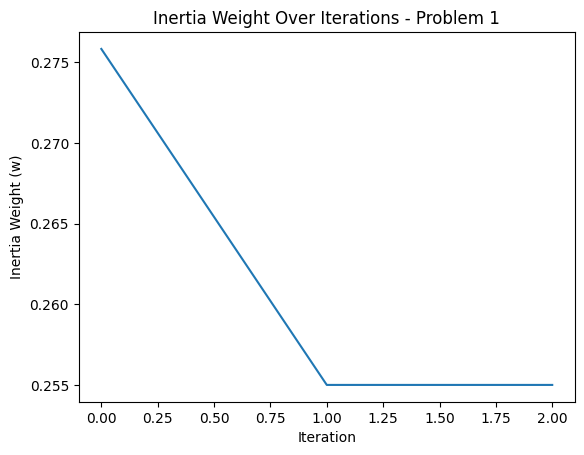

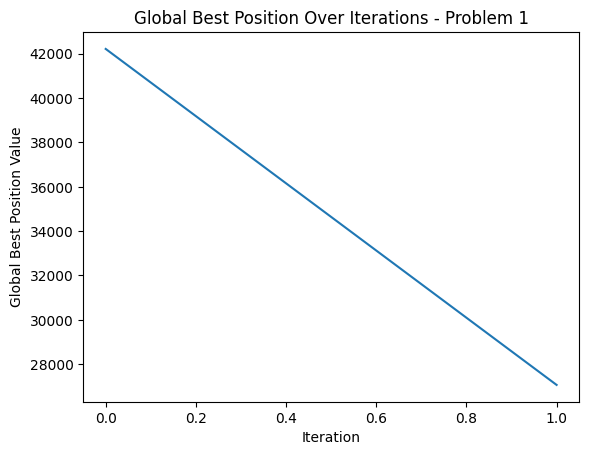




Problem 2 Best Cost: [43258.92802649 26404.2837635 ]
Problem 2 Best Position: 26404.28376350237


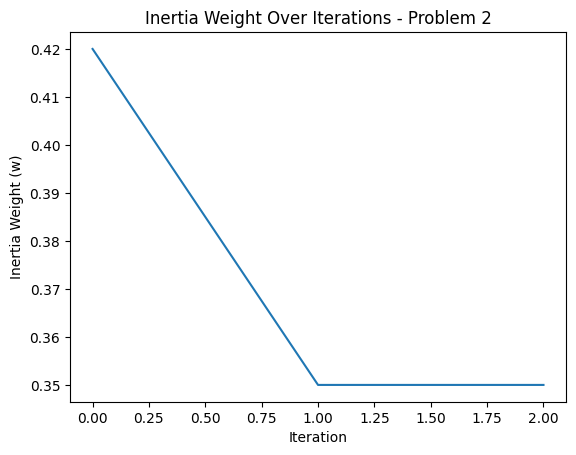

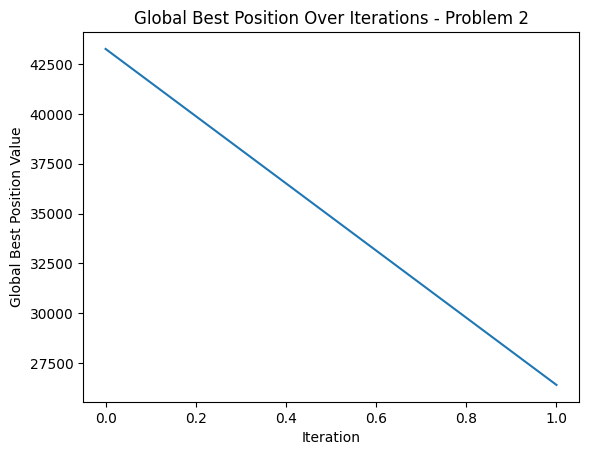




Problem 3 Best Cost: [52423.79676932 34639.85655661]
Problem 3 Best Position: 34639.85655660792


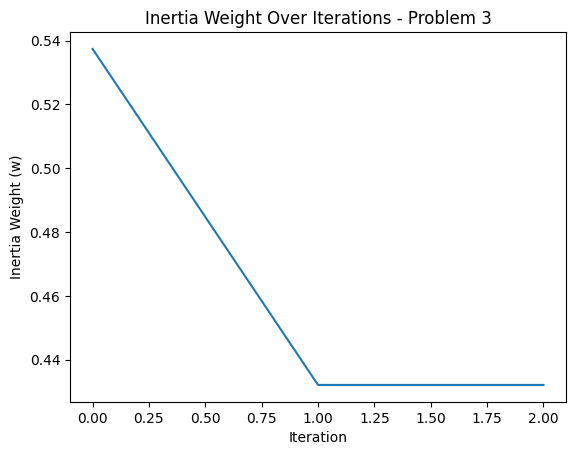

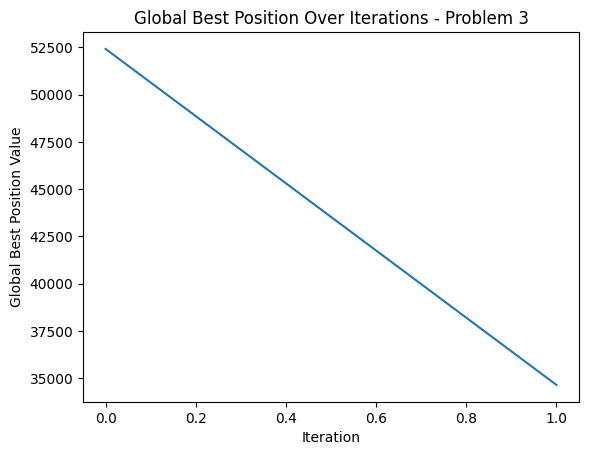




Problem 4 Best Cost: [48451.91724432 24037.22203656]
Problem 4 Best Position: 24037.22203656219


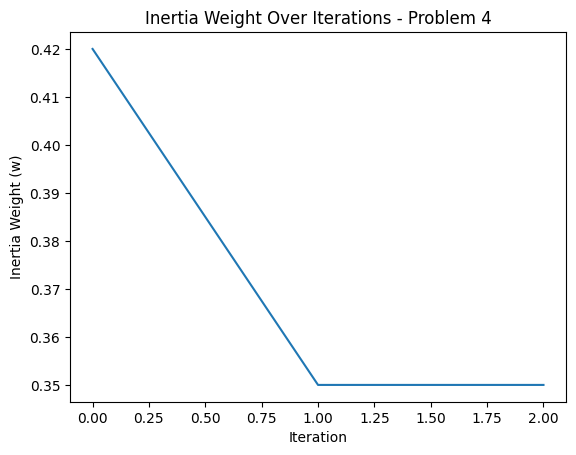

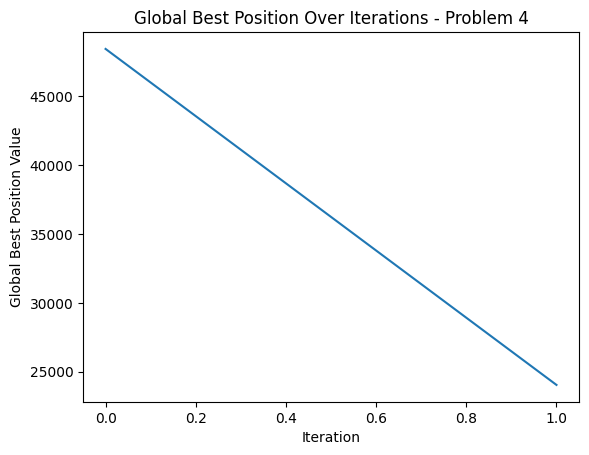




Problem 5 Best Cost: [50837.89862089 26128.19398851]
Problem 5 Best Position: 26128.193988507257


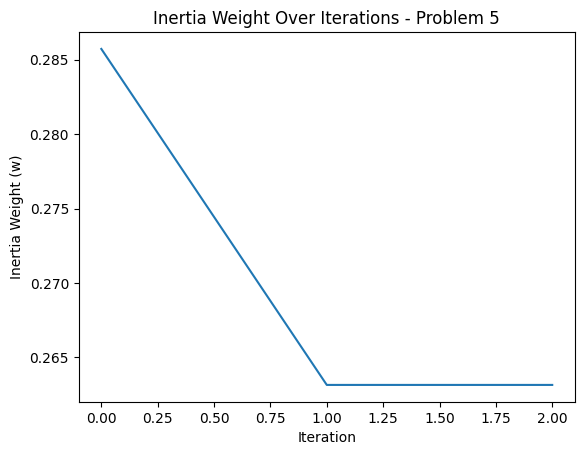

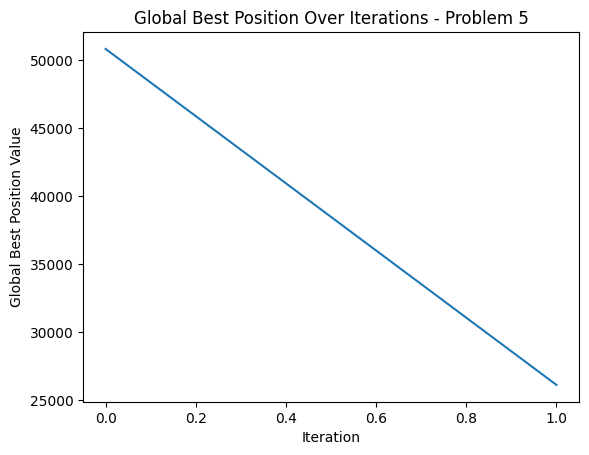




Problem 6 Best Cost: [52382.78674091 30007.14585615]
Problem 6 Best Position: 30007.14585614862


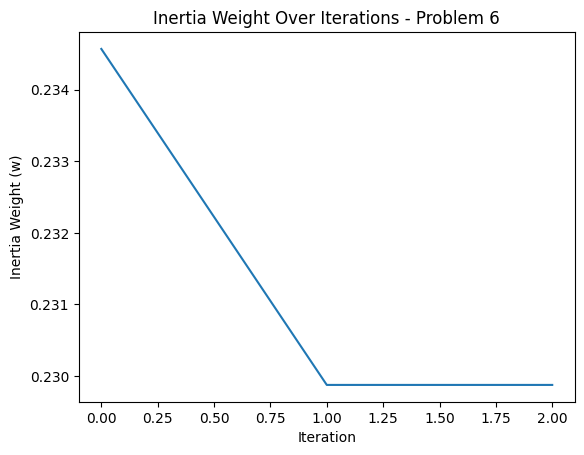

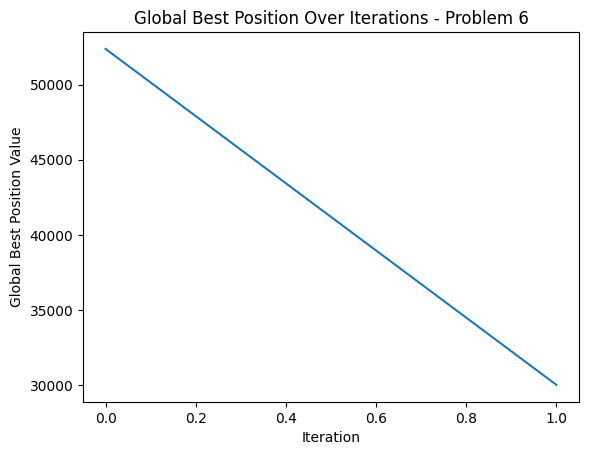




Problem 7 Best Cost: [42343.95206703 29221.15514563]
Problem 7 Best Position: 29221.155145629633


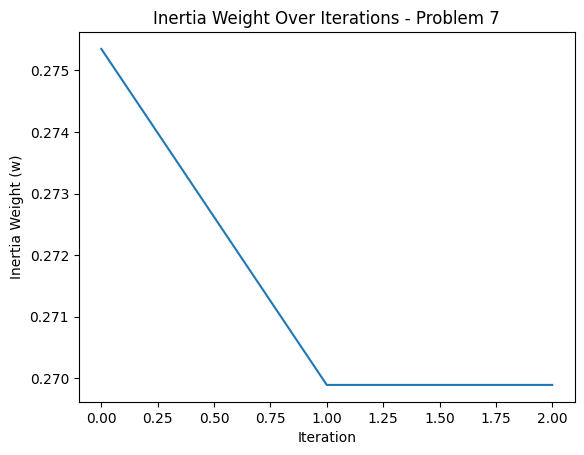

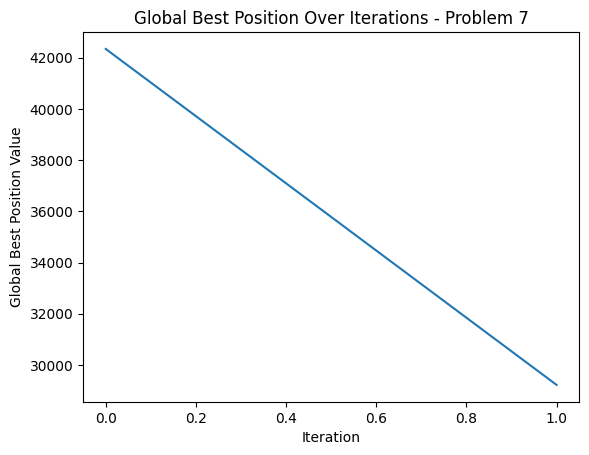




Problem 8 Best Cost: [52935.99884454 32224.75504632]
Problem 8 Best Position: 32224.755046321774


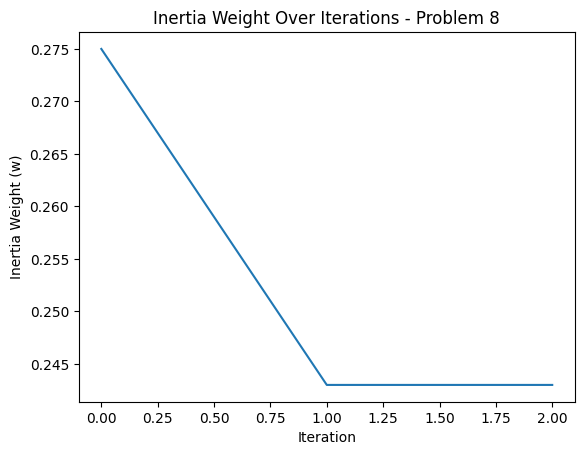

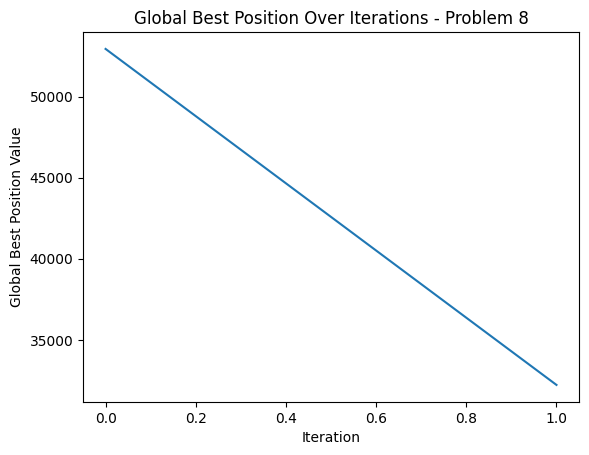




Problem 9 Best Cost: [37411.8542196  26513.35001518]
Problem 9 Best Position: 26513.350015178814


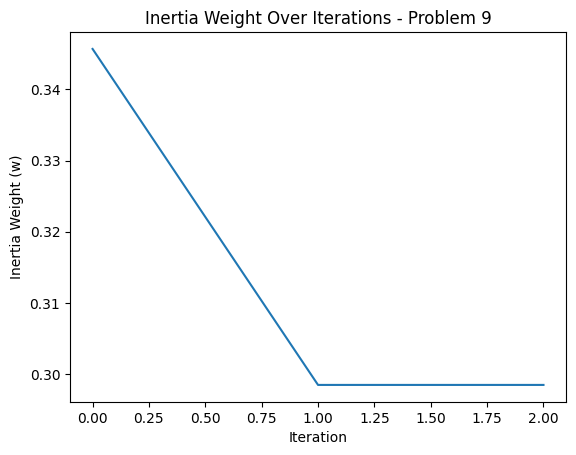

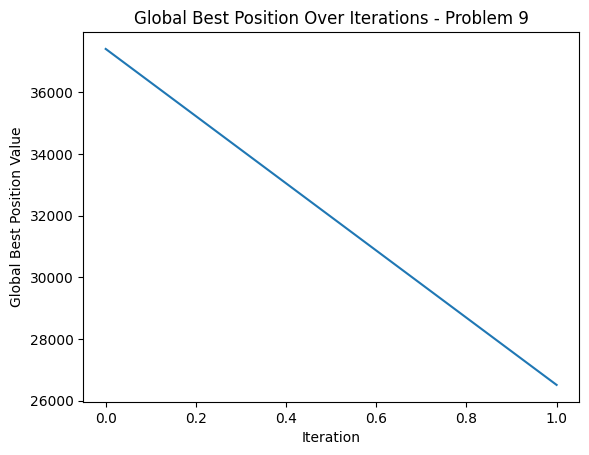




Problem 10 Best Cost: [42093.97538261 26308.16739957]
Problem 10 Best Position: 26308.16739956745


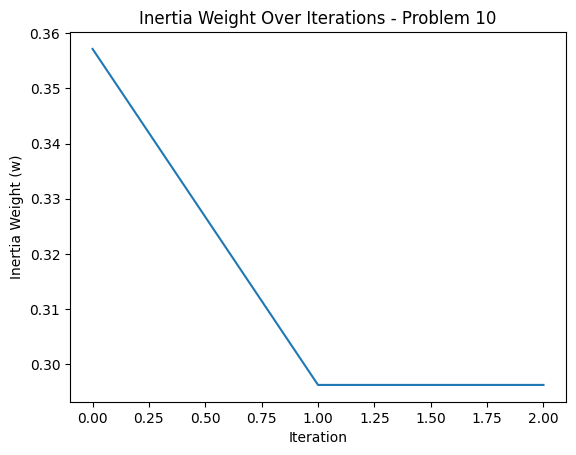

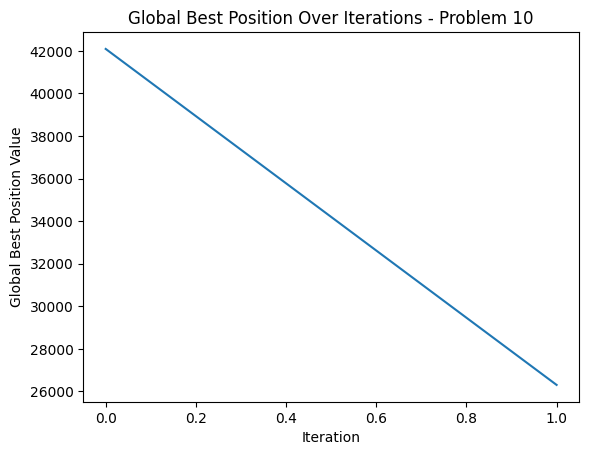




Problem 11 Best Cost: [45323.51230768 29980.10656259]
Problem 11 Best Position: 29980.1065625927


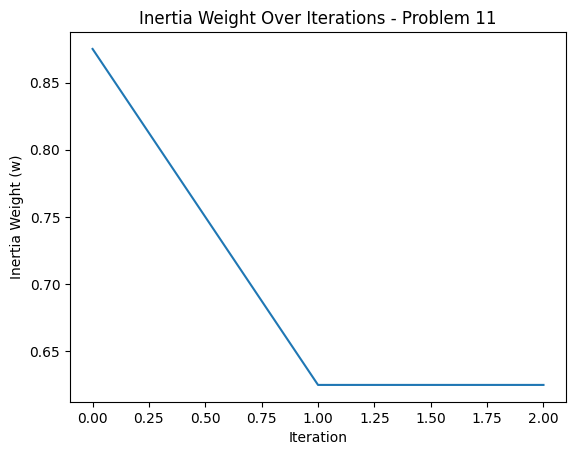

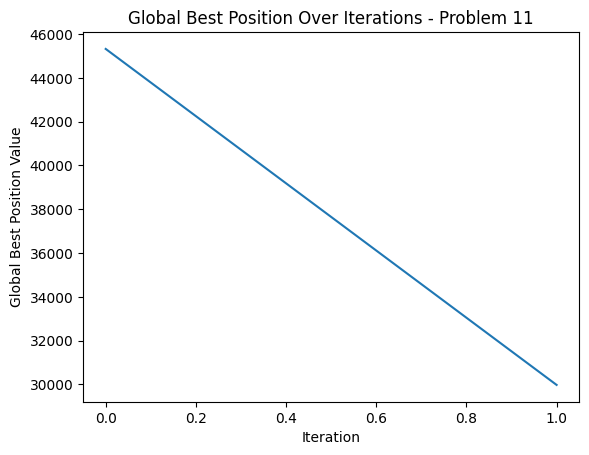




Problem 12 Best Cost: [39062.2908184  20337.23948094]
Problem 12 Best Position: 20337.239480935972


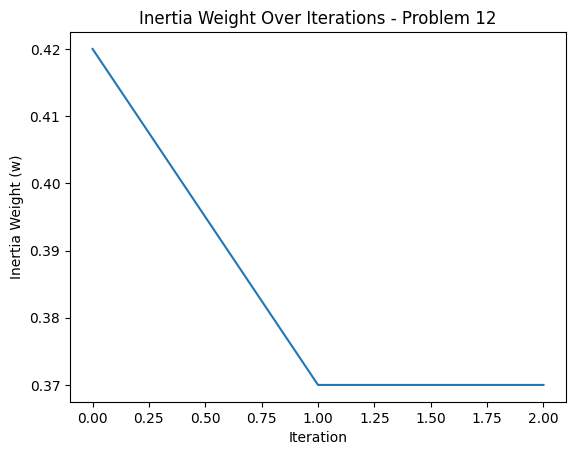

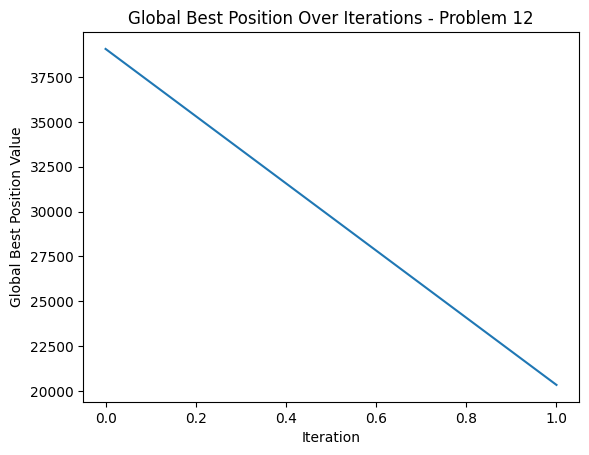




Problem 13 Best Cost: [38887.34335606 23356.4322871 ]
Problem 13 Best Position: 23356.43228710258


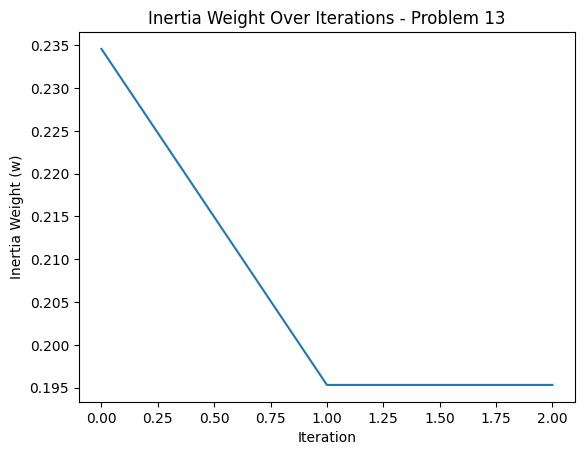

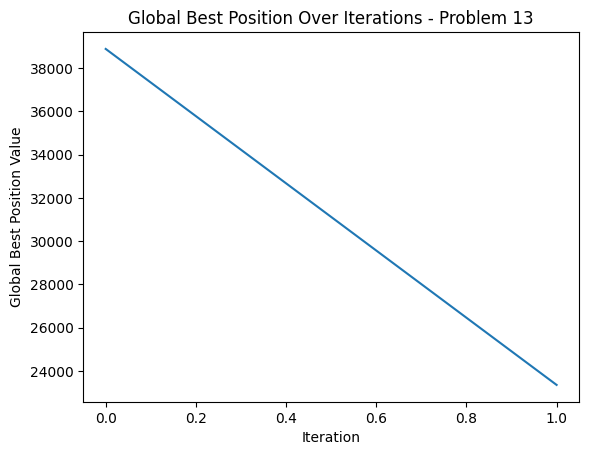




Problem 14 Best Cost: [39838.80920908 29183.43158989]
Problem 14 Best Position: 29183.431589886062


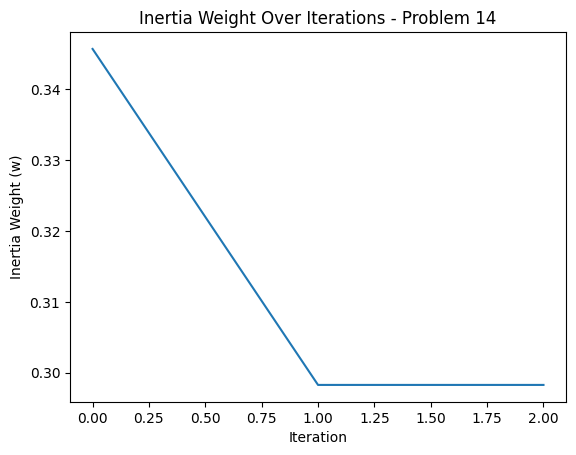

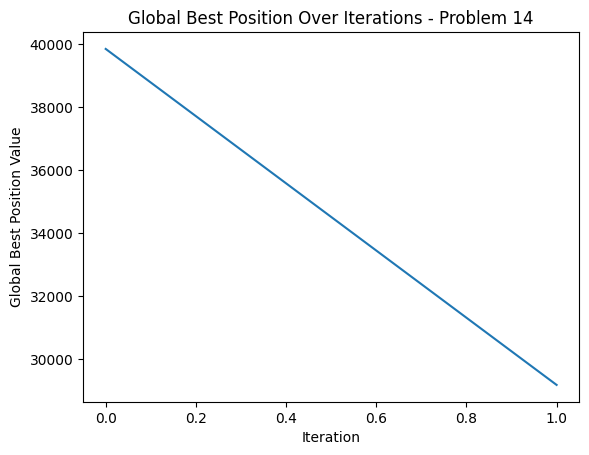




Problem 15 Best Cost: [48192.62113478 26773.76591964]
Problem 15 Best Position: 26773.76591963688


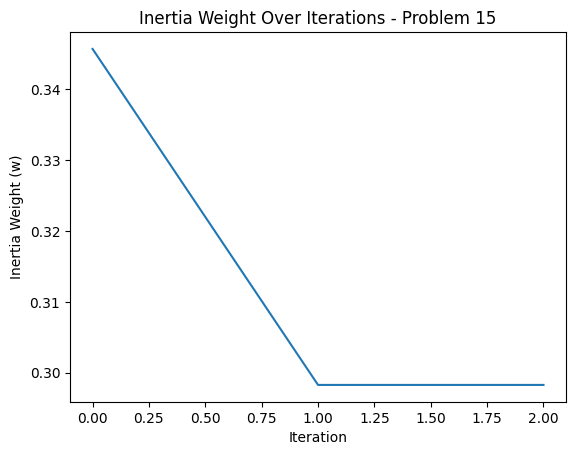

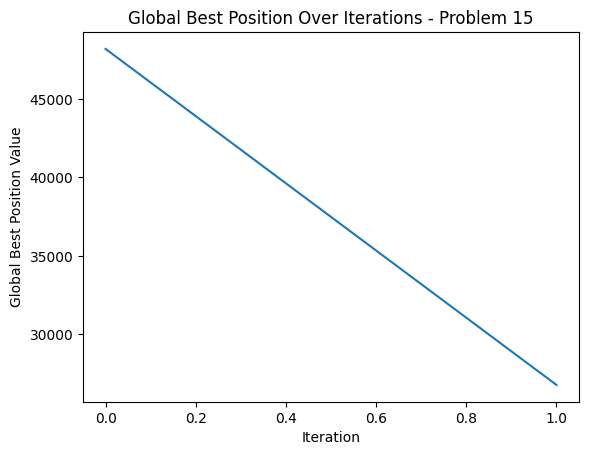




Problem 16 Best Cost: [48582.0373126  25521.74804728]
Problem 16 Best Position: 25521.748047276662


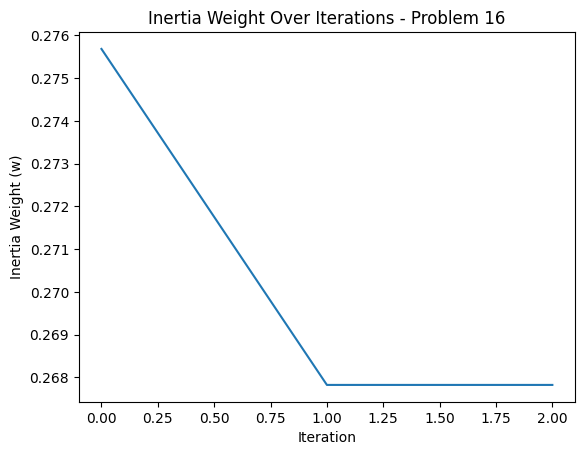

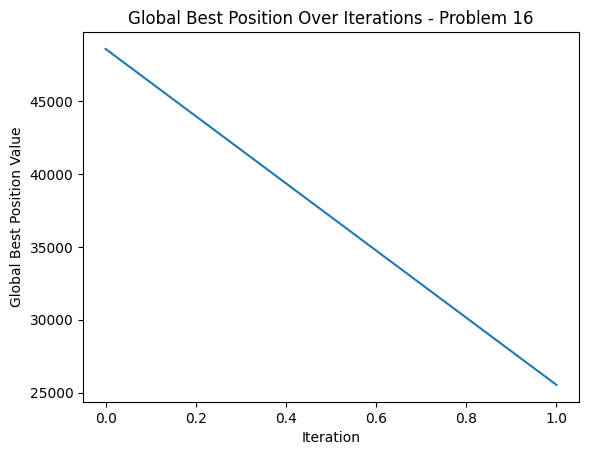




Problem 17 Best Cost: [42184.60145226 26376.71905366]
Problem 17 Best Position: 26376.719053657092


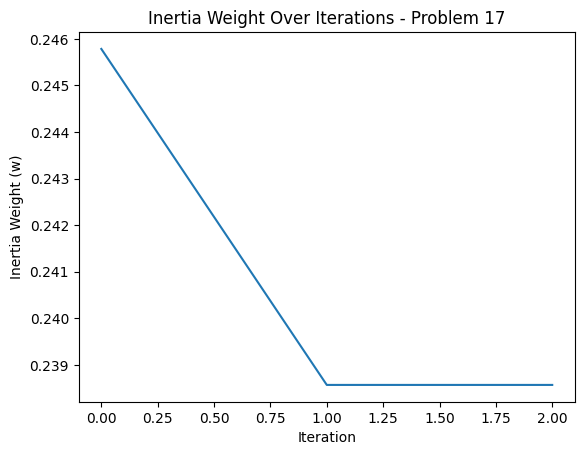

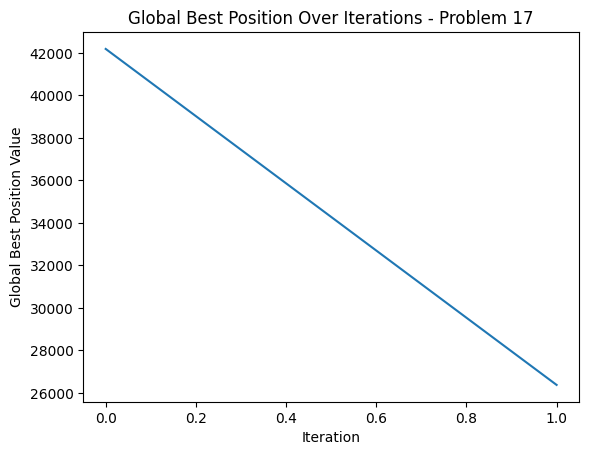




Problem 18 Best Cost: [44926.4718216  25289.87985173]
Problem 18 Best Position: 25289.879851726088


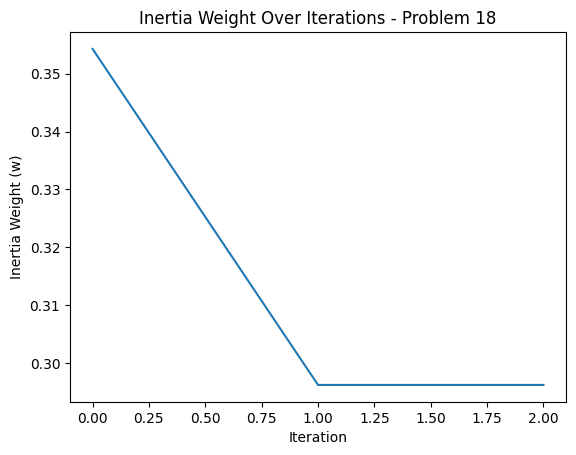

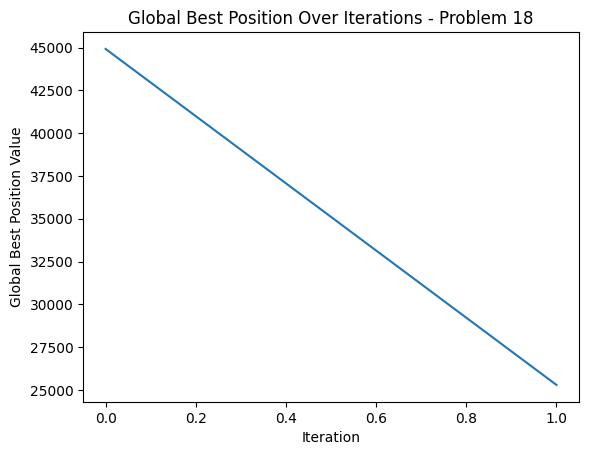




Problem 19 Best Cost: [52069.78407994 30200.68076199]
Problem 19 Best Position: 30200.680761990257


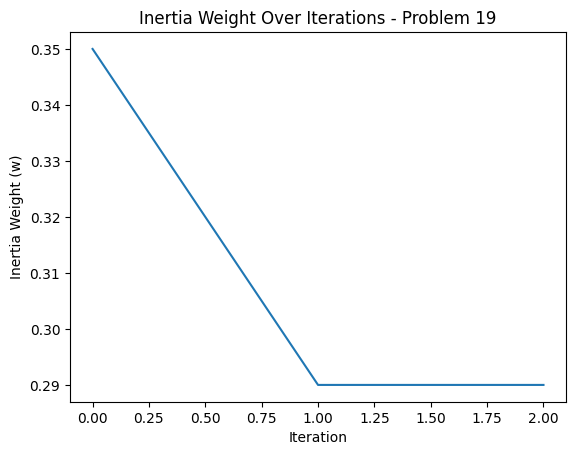

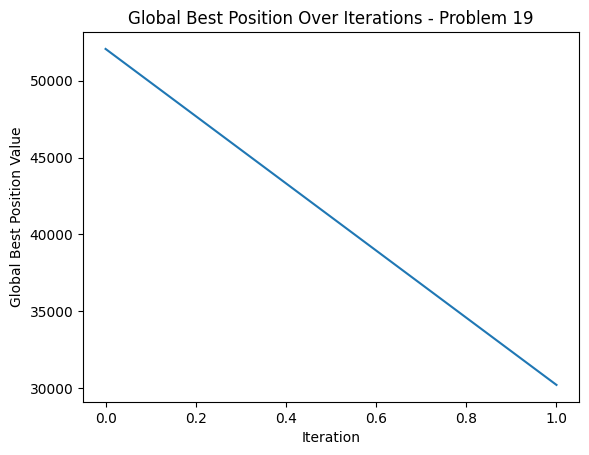




Problem 20 Best Cost: [49256.44948751 28760.16057335]
Problem 20 Best Position: 28760.16057334625


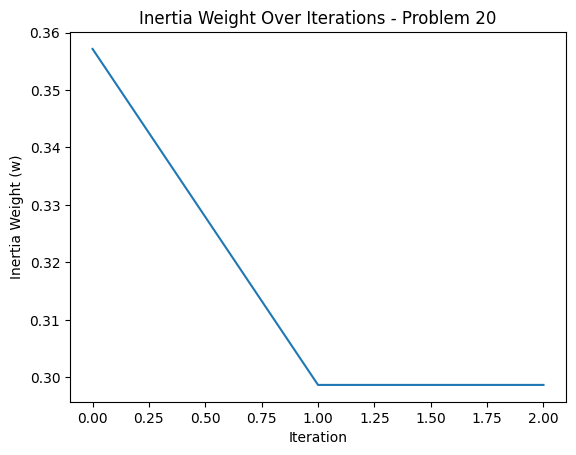

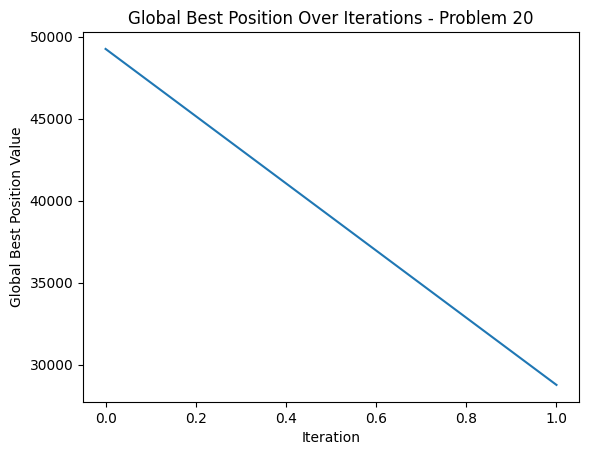




Problem 21 Best Cost: [49755.87990476 23354.88994413]
Problem 21 Best Position: 23354.88994413407


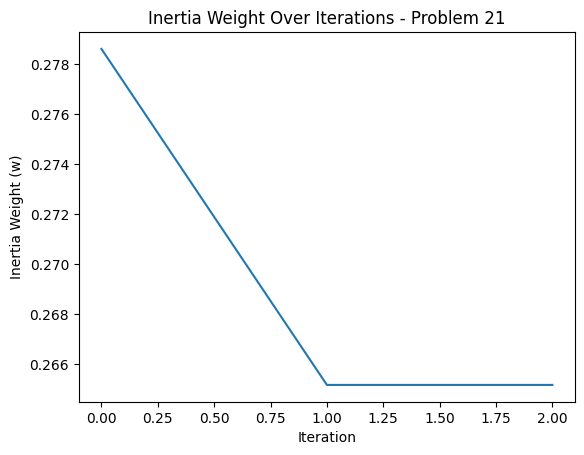

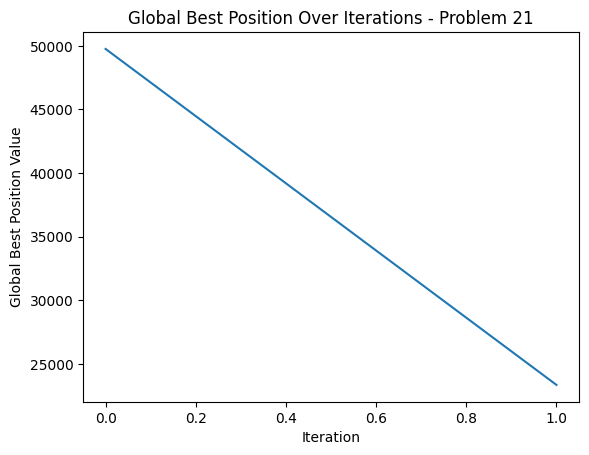




Problem 22 Best Cost: [47238.19952916 26758.55877512]
Problem 22 Best Position: 26758.558775123336


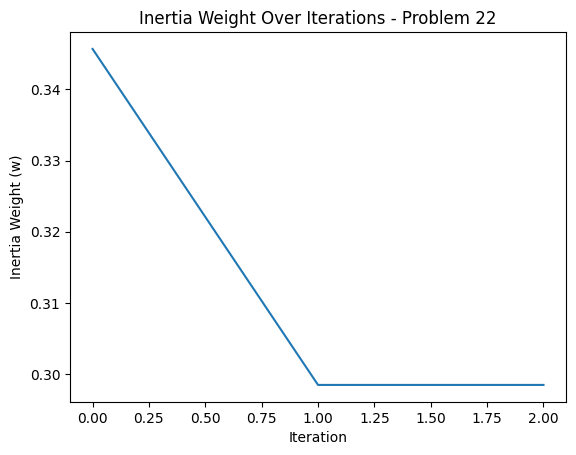

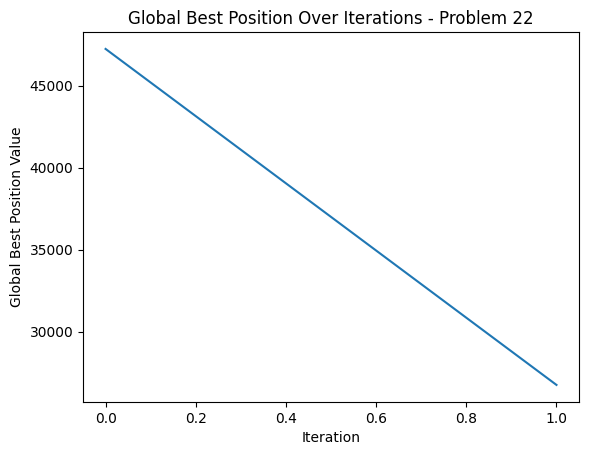




Problem 23 Best Cost: [50748.23900903 25940.93420256]
Problem 23 Best Position: 25940.93420256334


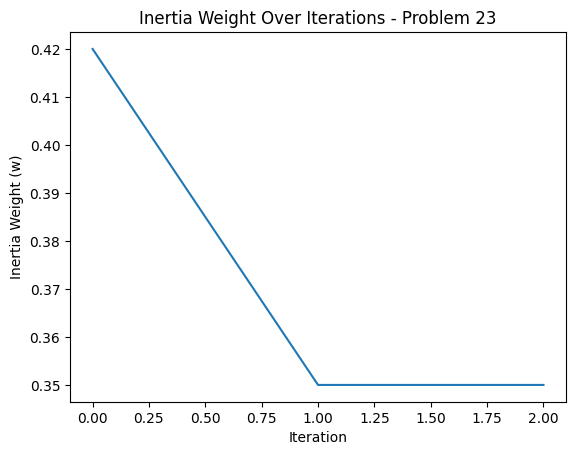

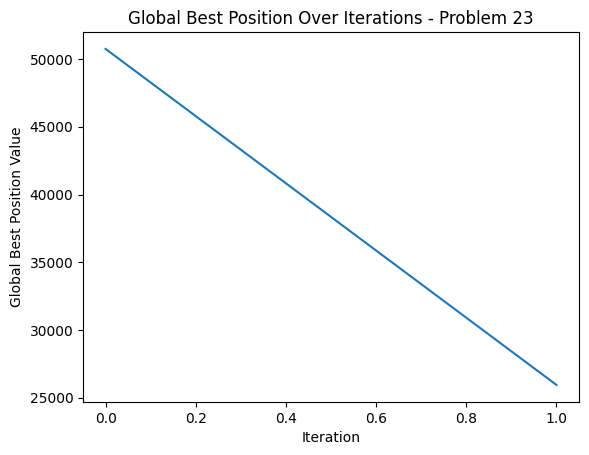




Problem 24 Best Cost: [39733.12554683 23813.27556037]
Problem 24 Best Position: 23813.275560370566


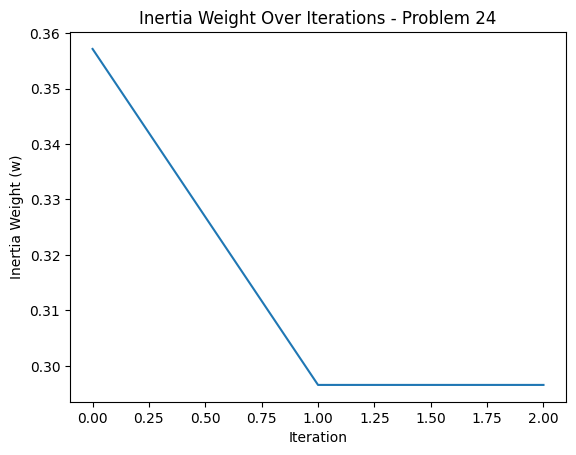

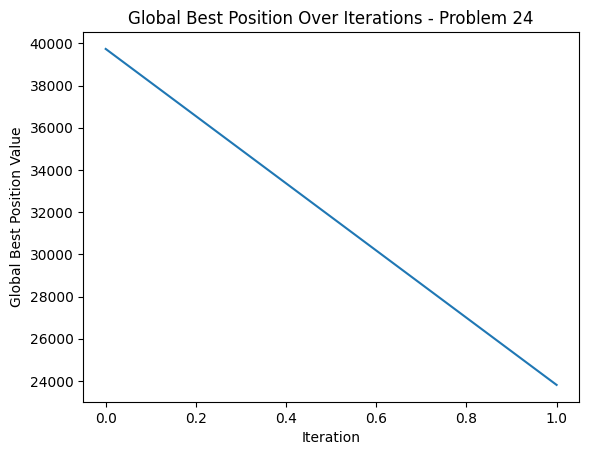

In [58]:
for prob in range(24):
    curr = prob + 1
    problem_results = results[curr]

    print("\n\n\nProblem", curr, "Best Cost:", problem_results['BestCost'])
    print("Problem", curr, "Best Position:", problem_results['BestPosition'])

    plt.plot(problem_results['w_values'])
    plt.xlabel('Iteration')
    plt.ylabel('Inertia Weight (w)')
    plt.title(f'Inertia Weight Over Iterations - Problem {curr}')
    plt.show()

    plt.plot(problem_results['g_values'])
    plt.xlabel('Iteration')
    plt.ylabel('Global Best Position Value')
    plt.title(f'Global Best Position Over Iterations - Problem {curr}')
    plt.show()